In [2]:
import matplotlib.pyplot as plt
from pathlib import Path

import gammapy
import numpy as np
import astropy
import regions
import scipy

print("gammapy:", gammapy.__version__)
print("numpy:", np.__version__)
print("astropy", astropy.__version__)
print("regions", regions.__version__)
print("scipy", scipy.__version__)


from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.io import fits
from astropy.table import Table
from astropy.time import Time
from astropy.coordinates import SkyCoord, Angle

from regions import CircleSkyRegion

from gammapy.data import DataStore, GTI, Observation, EventList
from gammapy.datasets import (FluxPointsDataset, MapDataset, MapDatasetEventSampler, 
                              Datasets, SpectrumDataset, SpectrumDatasetOnOff)
from gammapy.maps import MapAxis, WcsGeom, Map
from gammapy.irf import load_irf_dict_from_file
from gammapy.makers import SafeMaskMaker, SpectrumDatasetMaker, ReflectedRegionsBackgroundMaker, MapDatasetMaker
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    Model,
    Models,
    SkyModel,
    PowerLawSpectralModel,
    PowerLawNormSpectralModel,
    ExpCutoffPowerLawSpectralModel,
    PointSpatialModel,
    GaussianSpatialModel,
    TemplateSpatialModel,
    TemplateSpectralModel,
    FoVBackgroundModel,
)


import copy
import scipy.stats as stats

from gammapy.estimators import (
    FluxPoints, 
    FluxPointsEstimator, 
    TSMapEstimator
)

from regions import CircleSkyRegion

gammapy: 1.3
numpy: 2.1.3
astropy 6.1.6
regions 0.10
scipy 1.14.1


In [2]:
import warnings
from gammapy.utils.deprecation import GammapyDeprecationWarning
# 1. Hide the Gammapy “FixedPointingInfo will be required” notice
warnings.filterwarnings("ignore", category=GammapyDeprecationWarning)

In [3]:
BASE_PATH=Path("/Users/tharacaba/Desktop/Tesis_2/MASS_Thesis/simulations/Kornecki_starburst")

In [4]:
def save_figure(filename):       #routine for saving figures
    path = BASE_PATH / filename      #saving paths
    path.parent.mkdir(parents=True, exist_ok=True)  #create a directory
    plt.savefig(path, dpi=300, bbox_inches='tight')     #dpi is the resolution
    plt.clf()                #clear
    plt.close()

In [5]:
import os
Nsim = 100              #definition of simulation number

## Creation of needed directories

Nsims=f"/Users/tharacaba/Desktop/Tesis_2/MASS_Thesis/simulations/Kornecki_starburst/{Nsim}sims"
try:
    # Create target Directory
    os.mkdir(Nsims)
except FileExistsError:
    print("Directory " , Nsims ,  " already exists")
    
events=f"/Users/tharacaba/Desktop/Tesis_2/MASS_Thesis/simulations/Kornecki_starburst/{Nsim}sims/events"
try:
    os.mkdir(events)
except FileExistsError:
    print("Directory " , events ,  " already exists")   
    
bestfit=f"/Users/tharacaba/Desktop/Tesis_2/MASS_Thesis/simulations/Kornecki_starburst/{Nsim}sims/best-fit"
try:
    os.mkdir(bestfit)
except FileExistsError:
    print("Directory " , bestfit ,  " already exists")  

spectra=f"/Users/tharacaba/Desktop/Tesis_2/MASS_Thesis/simulations/Kornecki_starburst/{Nsim}sims/spectra"
try:
    os.mkdir(spectra)
    print("Directory " , spectra ,  " Created ") 
except FileExistsError:
    print("Directory " , spectra ,  " already exists")

Directory  /Users/tharacaba/Desktop/Tesis_2/MASS_Thesis/simulations/Kornecki_starburst/100sims  already exists
Directory  /Users/tharacaba/Desktop/Tesis_2/MASS_Thesis/simulations/Kornecki_starburst/100sims/events  already exists
Directory  /Users/tharacaba/Desktop/Tesis_2/MASS_Thesis/simulations/Kornecki_starburst/100sims/best-fit  already exists
Directory  /Users/tharacaba/Desktop/Tesis_2/MASS_Thesis/simulations/Kornecki_starburst/100sims/spectra  already exists


In [6]:
####
# MAP GEOMETRY
####

ENERGY_AXIS = MapAxis.from_energy_bounds(
    "0.1 TeV", "100.0 TeV", nbin=10, per_decade=True       #IRF range
)
ENERGY_AXIS_TRUE = MapAxis.from_energy_bounds(
    "0.01 TeV", "350 TeV", nbin=20, per_decade=True, name="energy_true"    #larger range for E_true
)
MIGRA_AXIS = MapAxis.from_bounds(
    0.5, 2, nbin=150, node_type="edges", name="migra"
)

center = SkyCoord.from_name("NGC 1068").icrs

offset = 0.5 * u.deg

pointing_position = center.directional_offset_by(
    position_angle=0 * u.deg, separation=offset
)

WCS_GEOM = WcsGeom.create(
    skydir=pointing_position,
    width=(10, 10),         #REMEMBER: if you want to point off-axis 4°, you need a wider field     
    binsz=0.02,          #binsize simulation << PSF 
    frame="icrs",
    axes=[ENERGY_AXIS],
)

In [7]:
MainSource = "NGC1068"        #here insert all the information that I want in the filename
MainSourceAn = "NGC1068_Kornecki"               #name that I have to put in the analysis

In [8]:
filename = "/Users/tharacaba/Desktop/Tesis_2/gammapy-datasets/1.3/cta-prod5-zenodo-fitsonly-v0/fits/CTA-Performance-prod5-v0.1-North-40deg.FITS/Prod5-North-40deg-AverageAz-4LSTs09MSTs.180000s-v0.1.fits"  
irfs = load_irf_dict_from_file(filename)

In [9]:
#########
# Empty dataset creation with infromation from IRF
########
empty = MapDataset.create(
    WCS_GEOM, 
    energy_axis_true=ENERGY_AXIS_TRUE, 
    migra_axis=MIGRA_AXIS,
    name="my-dataset",
)


#####
# IRF definition, exposure definition, observation definition--> see previous notebook
#####

LIVETIME = 100 * u.hr                          #observation time with units
ext = int(LIVETIME.value)                         # exposure time as integer"
obs_id="0001"                                     # obs_id could be everything


observation = Observation.create(
    obs_id=obs_id, pointing=pointing_position, livetime=LIVETIME, irfs=irfs 
) 


## which maps to make
maker = MapDatasetMaker(selection=["exposure", "background", "psf", "edisp"])    #with Edisp
#maker = MapDatasetMaker(selection=["exposure", "psf", "background"])          #without the Edisp


dataset = maker.run(empty, observation)

dataset.write(f"/Users/tharacaba/Desktop/Tesis_2/MASS_Thesis/simulations/Kornecki_starburst/dataset_{MainSource}_{ext}hr.fits", overwrite=True)
print(dataset)

MapDataset
----------

  Name                            : my-dataset 

  Total counts                    : 0 
  Total background counts         : 10823072.70
  Total excess counts             : -10823072.70

  Predicted counts                : 10823072.70
  Predicted background counts     : 10823072.70
  Predicted excess counts         : nan

  Exposure min                    : 5.62e+00 m2 s
  Exposure max                    : 6.00e+11 m2 s

  Number of total bins            : 7500000 
  Number of fit bins              : 7500000 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




Models

Component 0: SkyModel

  Name                      : NGC1068_Kornecki
  Datasets names            : None
  Spectral model type       : TemplateSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    lon_0                 (frozen):     40.669       deg         
    lat_0                 (frozen):     -0.013       deg         

Component 1: FoVBackgroundModel

  Name                      : my-dataset-bkg
  Datasets names            : ['my-dataset']
  Spectral model type       : PowerLawNormSpectralModel
  Parameters:
    norm                          :      1.000   +/-    0.00             
    tilt                  (frozen):      0.000                   
    reference             (frozen):      1.000       TeV         




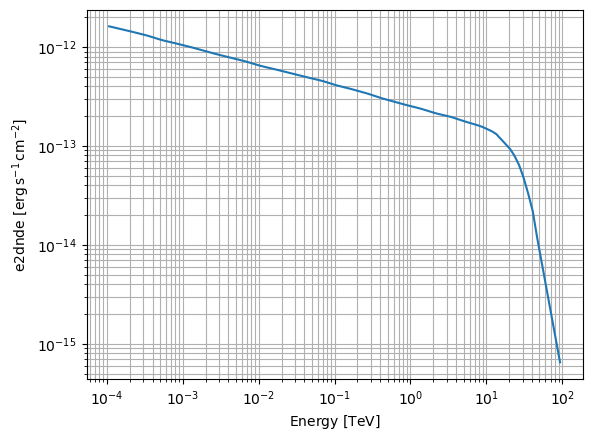

In [10]:
from astropy.io import ascii

# Source
point_model = PointSpatialModel(
    lon_0="40.669 deg", 
    lat_0="-0.013 deg", 
    frame='icrs'
)

# Template spectral model. Defined by values from Kornechi+ 2025
data = ascii.read("/Users/tharacaba/Desktop/Tesis_2/MASS_Thesis/simulations/Kornecki_starburst/Kornecki_Starburst.csv")

energy = data['x'] *u.TeV
values = data['y'] *u.erg / (u.cm **2.0 * u.s)

energy_MeV = energy.to(u.MeV)

values = values.to(u.MeV / (u.cm ** 2.0 * u.s))
values_MeV = values / energy_MeV**2  # divide by energy to get dN/dE


energy_bounds = [0.0001, 100] * u.TeV
spectral_model = TemplateSpectralModel(energy=energy_MeV, values=values_MeV)

# Background
bkg_model = FoVBackgroundModel(dataset_name="my-dataset")



sky_model = SkyModel(
                    spectral_model=spectral_model,
                    spatial_model=point_model,
 #                   temporal_model=expdecay_model,
                    name=MainSourceAn,
                    )

# Define the whole model
models = Models([sky_model, bkg_model])


models[0].spatial_model.parameters['lon_0'].frozen=True       #Spatial coordinate freezed
models[0].spatial_model.parameters['lat_0'].frozen=True

print(models) 

#print(models.to_yaml())
# save it to disk
file_model = "/Users/tharacaba/Desktop/Tesis_2/MASS_Thesis/simulations/Kornecki_starburst/NGC1068_Nsim_Kornecki.yaml"
models.write(file_model, overwrite=True)

spectral_model.plot(energy_bounds, sed_type="e2dnde")
plt.grid(which="both")

In [11]:
from gammapy.data import observatory_locations

exp = [100]     

for j in exp:         #loop on exposure times
    ext = int(j)      # to facilitate the references in the loops
    dataset = MapDataset.read(f'/Users/tharacaba/Desktop/Tesis_2/MASS_Thesis/simulations/Kornecki_starburst/dataset_{MainSource}_{ext}hr.fits', name="my-dataset") #read the one that we created
    dataset.models = models     
    dataset_original = models.copy()         #this will be useful for the final plot
    for i in np.arange(Nsim):                 # we simulate N times
        observation = Observation.create(
        obs_id=i, pointing=pointing_position, livetime=j*u.hr, irfs=irfs, tstart = 30 * u.min, reference_time = Time("2026-05-28T00:00:00", format="isot", scale="utc"),
        location = observatory_locations["cta_north"]
        )
        
        sampler = MapDatasetEventSampler(random_state=i)
        events = sampler.run(dataset, observation)

        observation.events = events
        observation.write(f"/Users/tharacaba/Desktop/Tesis_2/MASS_Thesis/simulations/Kornecki_starburst/{Nsim}sims/events/{MainSource}_{ext}hr_events_{i}.fits", include_irfs=False, overwrite=True)

The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta informa

In [3]:
import glob, os, itertools
input_filenames = []
input_filenames.append(glob.glob(os.path.join("/Users/tharacaba/Desktop/Tesis_2/MASS_Thesis/simulations/Kornecki_starburst/100sims/events/", '*.fits')))
input_filenames = tuple(itertools.chain.from_iterable(input_filenames))

datastore = DataStore.from_events_files(np.sort(input_filenames), irfs_paths="/Users/tharacaba/Desktop/Tesis_2/gammapy-datasets/1.3/cta-prod5-zenodo-fitsonly-v0/fits/CTA-Performance-prod5-v0.1-North-40deg.FITS/Prod5-North-40deg-AverageAz-4LSTs09MSTs.180000s-v0.1.fits")
datastore.hdu_table.write("/Users/tharacaba/Desktop/Tesis_2/MASS_Thesis/simulations/Kornecki_starburst/hdu-index.fits.gz", overwrite=True)
datastore.obs_table.write("/Users/tharacaba/Desktop/Tesis_2/MASS_Thesis/simulations/Kornecki_starburst/obs-index.fits.gz", overwrite=True)

In [6]:
from gammapy.maps import MapAxis, RegionGeom
# let's load the previously created Observation index files:

center = SkyCoord.from_name("NGC 1068").icrs

offset = 0.5 * u.deg

pointing_position = center.directional_offset_by(
    position_angle=0 * u.deg, separation=offset
)

observations = datastore.get_observations(obs_id=list(datastore.obs_table['OBS_ID']))

# we consider a square map of size 2.0 deg, spatially binned with bins of 0.02 deg;
# we define the ON region, assuming a circle of 0.2 deg of radius, for the source;
width = 2.0  #deg
binsz = 0.02 #deg
radius= 0.11  #deg

# let's define an exclusion region, in order to better estimate the bkg:
target_position = SkyCoord(40.669 * u.deg, -0.013 * u.deg, frame="icrs", unit="deg")
on_region_radius = Angle(radius * u.deg)
on_region = CircleSkyRegion(center=target_position, radius=on_region_radius)

npix = int(width/binsz)

exclusion_region = CircleSkyRegion(
    center=target_position,
    radius=radius * u.deg,
)

geom_excl = WcsGeom.create(
    npix=(npix, npix), binsz=binsz, skydir=target_position.galactic, proj="TAN", frame="galactic"
    #npix=(npix, npix), binsz=binsz, skydir=w1.galactic, proj="TAN", frame="galactic"
)

exclusion_mask = ~geom_excl.region_mask([exclusion_region])

# # Create the reconstruced energy range:
# e_min, e_max = 0.1 * u.TeV, 100 * u.TeV

energy_bounds=[10 * u.GeV, 10 * u.TeV]

energy_axis = MapAxis.from_energy_bounds(
    energy_bounds[0], energy_bounds[1], nbin=10, per_decade=True, unit="TeV", name="energy"
)

# Reduced IRFs are defined in true energy (i.e. not measured energy).
energy_axis_true = MapAxis.from_energy_bounds(
    energy_bounds[0] * 0.8,
        energy_bounds[1] * 1.2, nbin=13, per_decade=True, unit="TeV", name="energy_true"
)

# geometry defining the ON region and SpectrumDataset based on it
geom = RegionGeom.create(region=on_region, axes=[energy_axis])

dataset_empty = SpectrumDataset.create(geom=geom, energy_axis_true=energy_axis_true)

dataset_maker = SpectrumDatasetMaker(
    containment_correction=True, selection=["counts", "exposure", "edisp"]
)

# tell the background maker to determine the reflected regions, excluding the source region:
maker_fov = ReflectedRegionsBackgroundMaker(exclusion_mask=exclusion_mask)

# let's impone a safe range for the analysis: we consider only events at a distance from the pointing direction < 1 deg.
safe_mask_maker = SafeMaskMaker(
        methods=["aeff-max"], aeff_percent=10, position=pointing_position
    )

# create a counts map for visualisation later...
counts = Map.create(skydir=target_position, width=3)

# let's create the dataset for each observation and stack them all:
datasets = Datasets()

# let's loop over observations
for observation in observations:
    # generate a dataset object
    dataset = dataset_maker.run(
        dataset_empty.copy(name=str(observation.obs_id)), observation
    )
    # fill the dataset with the events of the observation
    counts.fill_events(observation.events)

    # calculate the bkg
    dataset_on_off = maker_fov.run(dataset, observation)
    # set a safe range for the analysis
    dataset_on_off = safe_mask_maker.run(dataset_on_off, observation)

    datasets.append(dataset_on_off)

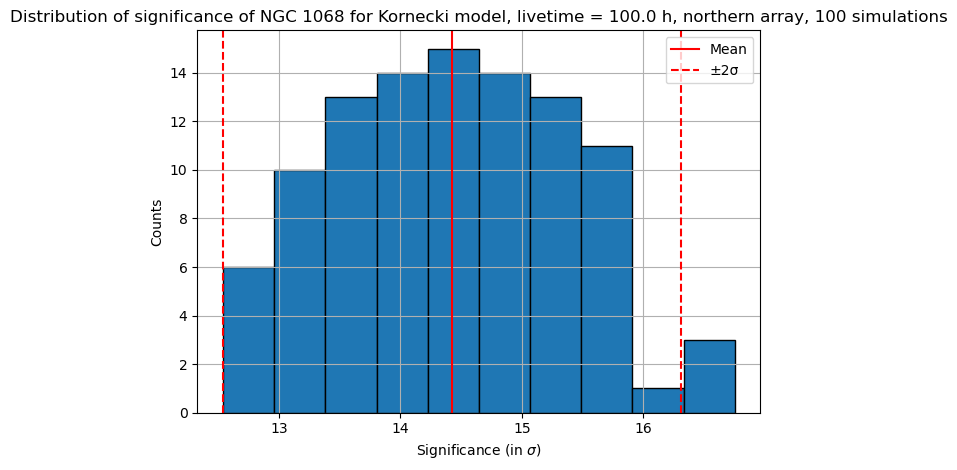

Significance : 14.42 +/- 0.94


In [8]:
from gammapy.stats import WStatCountsStatistic

LIVETIME = 100 * u.hr  

# Define alpha value used for all datasets
alpha = 0.083

# Container for significances
sig_distrib = []

# Loop through all datasets
for dataset in datasets:
    bin_index = dataset.mask_safe.quantity

    on_events = dataset.counts.data[bin_index].sum()
    off_events = dataset.counts_off.data[bin_index].sum()

    # Calculate significance using WStat
    stat = WStatCountsStatistic(on_events, off_events, alpha)
    significance = stat.sqrt_ts

    sig_distrib.append(significance)

# Convert to numpy array
sig_distrib = np.array(sig_distrib)

# Calculate mean and std
mean = sig_distrib.mean()
std = sig_distrib.std()

# Plot histogram
plt.figure()
plt.hist(sig_distrib, bins=10, edgecolor="black")
plt.axvline(mean, color="red", label="Mean")

# ±2σ lines
plt.axvline(mean + 2 * std, color="red", linestyle="--", label="±2σ")
plt.axvline(mean - 2 * std, color="red", linestyle="--")

plt.xlabel(r"Significance (in $\sigma$)")
plt.ylabel("Counts")
plt.title(f"Distribution of significance of NGC 1068 for Kornecki model, livetime = {LIVETIME}, northern array, 100 simulations")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print results
print(f"Significance : {mean:.2f} +/- {std:.2f}")